# Chennai Water Management
## Exploratory Analysis and Machine Learning

Chennai is a city located in the Indian state Tamil Nadu.  It serves as the capital of Tamil Nadu, and the city and surrounding area serve as a major economic centers in India.  It is also the place where both my parents (and most of my family) were born.

Recently this area has been suffering from serious water shortage.  This is due in part to two years of inadequate monsoon seasons, but increasing urbanization have caused some encroachment on water bodies in and around the region.  In this notebook I'm going through a dataset posted on Kaggle with the reservoir levels and rainfall levels in Chennai from 2004 until June 2019.  I'll be looking through to see if we can identify any trends in the data, and by providing visuals hopefully I can share just how dire the situation in Chennai is.

---

## Reading in the data

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

Since both input files have the same format (a date column and then 4 columns specifying areas in Chennai and their respective reservoir/rainfall levels) we can define a standard method to read in the data, appropriately parse the date column, and return a sorted frame.  We sort just in case the data itself does not come to us sorted, and sorting based on time helps us identify any trends in the data, including whether or not we can identify a downward trend in reservoir levels lately.

In [2]:
def read_input_file(filepath):
    """Reads in the input files located by the filepath <str> argument and returns a parsed dataframe."""
    
    frame = pd.read_csv(filepath)
    frame['Date'] = pd.to_datetime(frame['Date'], format='%d-%m-%Y')
    frame = frame.sort_values('Date', ascending=True).reset_index(drop=True)
    return frame

In [3]:
reservoir_levels = read_input_file(r'chennai-water-management/chennai_reservoir_levels.csv')
rainfall = read_input_file(r'chennai-water-management/chennai_reservoir_rainfall.csv')

---

## Taking a first look

So first let's take a look at the data we have, we can verify that the two dataframes have the same format of rows and columns.

In [4]:
reservoir_levels.head()

,Date,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
0,2004-01-01,3.9,0.0,268.0,0.0
1,2004-01-02,3.9,0.0,268.0,0.0
2,2004-01-03,3.9,0.0,267.0,0.0
3,2004-01-04,3.9,0.0,267.0,0.0
4,2004-01-05,3.8,0.0,267.0,0.0


In [5]:
rainfall.head()

,Date,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
0,2004-01-01,0.0,0.0,0.0,0.0
1,2004-01-02,0.0,0.0,0.0,0.0
2,2004-01-03,0.0,0.0,0.0,0.0
3,2004-01-04,0.0,0.0,0.0,0.0
4,2004-01-05,0.0,0.0,0.0,0.0


Note that there's no missing data here, we can verify by checking with `.isnull()` and then summing

In [6]:
print(reservoir_levels.isnull().sum(), '\n\n', rainfall.isnull().sum())

Date               0
POONDI             0
CHOLAVARAM         0
REDHILLS           0
CHEMBARAMBAKKAM    0
dtype: int64 

 Date               0
POONDI             0
CHOLAVARAM         0
REDHILLS           0
CHEMBARAMBAKKAM    0
dtype: int64


It might also help if we know the date range that this data encompasses.

In [7]:
start_date, end_date = reservoir_levels['Date'].min(), reservoir_levels['Date'].max()
print('Dataset Start Date:', start_date.strftime('%d-%b-%y'))
print('Dataset End Date:', end_date.strftime('%d-%b-%y'))

Dataset Start Date: 01-Jan-04
Dataset End Date: 17-Jun-19


Lets also take a look at a quick description of the columns so we can get an idea of the range of values we have to work with.

In [8]:
reservoir_levels.describe()

,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
count,5647.000000,5647.000000,5647.000000,5647.000000
mean,1133.272203,240.020572,1568.345573,1321.381645
std,1026.009311,274.601731,890.363617,957.057834
min,0.900000,0.000000,0.000000,0.000000
25%,213.000000,22.300000,849.000000,471.500000
50%,782.000000,92.000000,1630.000000,1225.000000
75%,2006.000000,460.000000,2236.000000,2083.000000
max,3231.000000,896.000000,3300.000000,3396.000000


In [9]:
rainfall.describe()

,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
count,5647.000000,5647.000000,5647.000000,5647.000000
mean,3.364486,3.617177,3.756862,3.923862
std,12.755029,14.078840,15.060551,16.287227
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,300.000000,293.000000,320.000000,475.000000


Based on the descriptions above, it seems like rainfall levels are pretty sparse, the 75th percentile for each region is 0.  Maybe taking a quick visual look at the data we have will help us out.

---

## Visualization

Let's try to take an initial look at the reservoir and rainfall levels in Chennai over time.

/home/mark/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


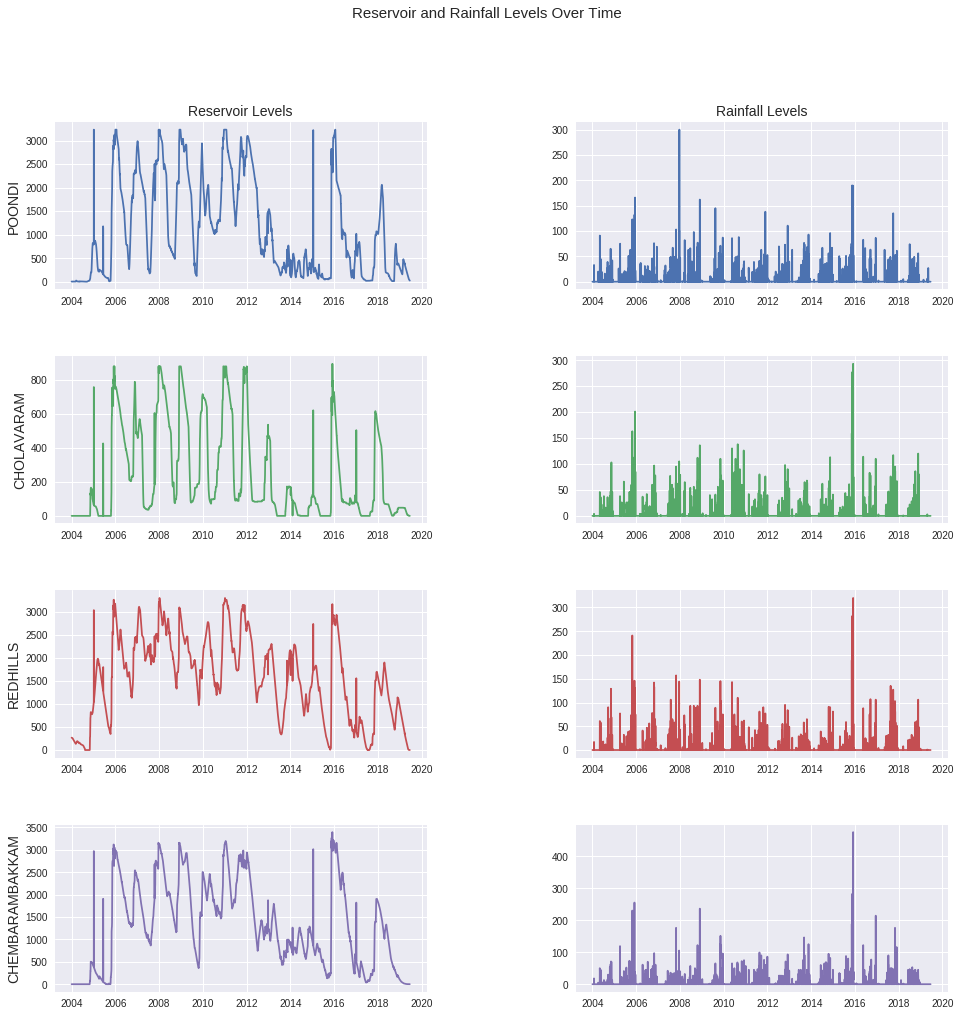

In [10]:
def plot_rainfall_and_reservoir_levels(reservoir_levels, rainfall, type='line', alpha=1):
    """
    Creates 6 plots, 4 rows and 2 columns, with one row per region in Chennai where the first
    "cell" holds the reservoir levels over time and the second holds rainfall levels over time.
    The 'type' variable determines the output is a line plot (type = 'line') or if the output is
    a barplot (type != 'line').
    """
    fig, ax = plt.subplots(4, 2, figsize=(16, 16))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for index, column in enumerate(reservoir_levels.columns[1:]):
        c = colors[index]
        if type == 'line':
            ax[index][0].plot(reservoir_levels['Date'], reservoir_levels[column], color=c, alpha=alpha)
            ax[index][1].plot(rainfall['Date'], rainfall[column], color=c, alpha=alpha)
        else:
            ax[index][0].bar(reservoir_levels['Date'], reservoir_levels[column], color=c, alpha=alpha)
            ax[index][1].bar(rainfall['Date'], rainfall[column], color=c, alpha=alpha)
        ax[index][0].set_ylabel(column, size=14)
    ax[0][0].set_title('Reservoir Levels', size=14)
    ax[0][1].set_title('Rainfall Levels', size=14)
    fig.suptitle('Reservoir and Rainfall Levels Over Time', size=15)

plot_rainfall_and_reservoir_levels(reservoir_levels, rainfall)

So based on what we see above it does look like rainfall and reservoir levels are tied to eachother, which may not be a shocking finding but it's always worth taking a quick look to make sure your intuition is correct.  It also appears that despite these regions having mostly similar amounts of rainfall (except for Chembarambakkam), they may have wildly different reservoir levels.  The pattern in the data is cyclical, implying that the reservoirs drain faster at certain times and fill faster at other times.

Cholavaram for has lower reservoir levels than any of the other regions despite having rainfall levels that look similar to Redhills.  Lets see if we can find out how correlated these values are.  Using scatter matrix would be helpful, but since we have two separate frames with similar column names we can also create four new plots with the points from each region.

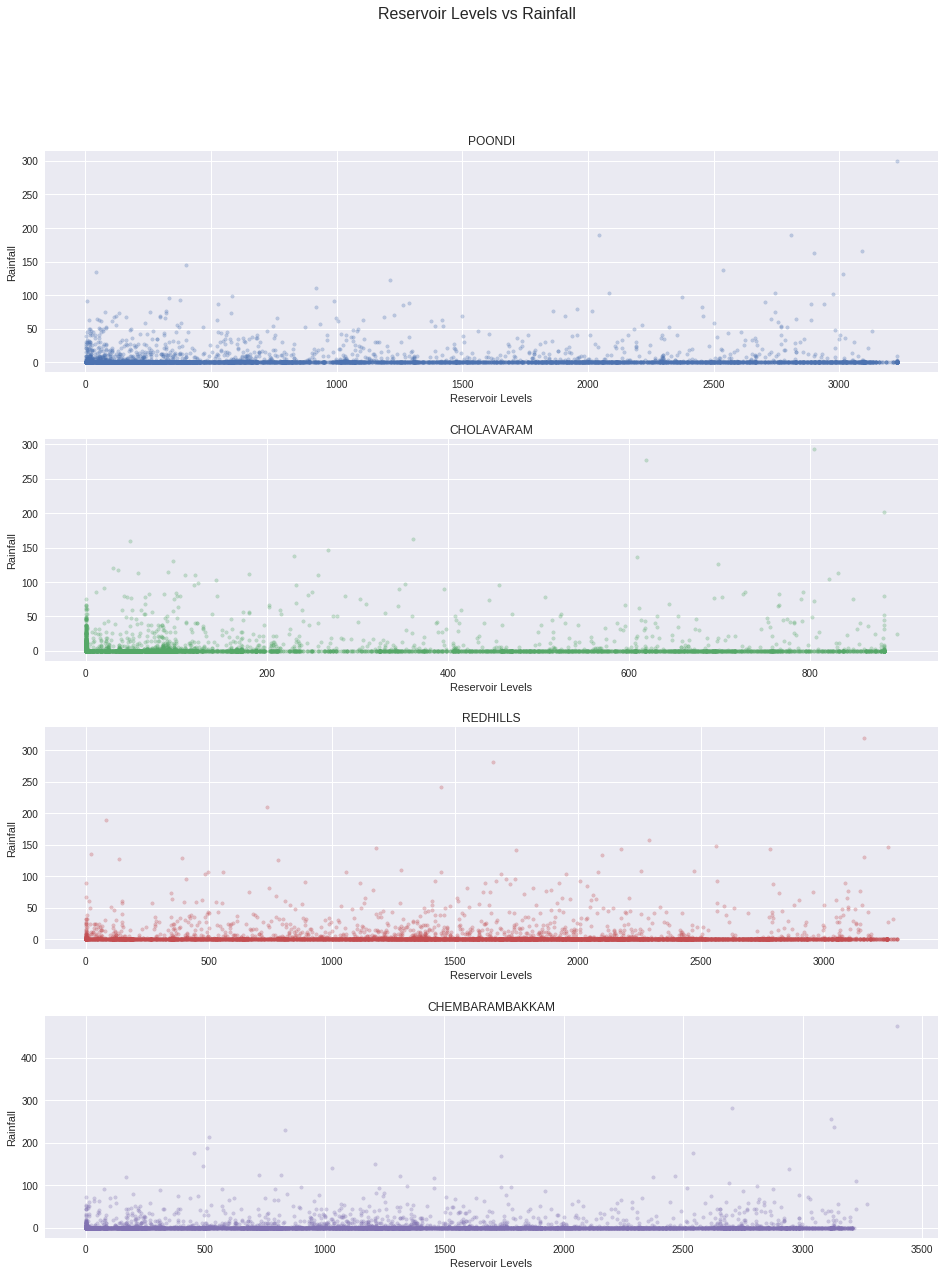

In [11]:
fig, ax = plt.subplots(4, 1, figsize=(16, 20))
for index, column in enumerate(reservoir_levels.columns[1:]):
    ax[index].scatter(reservoir_levels[column], rainfall[column], marker='.', color=colors[index], alpha=0.3)
    ax[index].set_ylabel('Rainfall')
    ax[index].set_title(column)
    ax[index].set_xlabel('Reservoir Levels')
fig.suptitle('Reservoir Levels vs Rainfall', size=16)
fig.subplots_adjust(hspace=0.3)

There's a lot of data here, it can be a little hard to see trends.  Right off the bat, there doesn't seem to be much of a linear correlation between the two variables.  We might expect this, the effects of rainfall may last for many days after, and if the rainfall and reservoir level data were collected at different timepoints during the day we wouldn't necessarily expect a strong correlation between the variables on the same day.  Let's see what we can get out of the dataset by aggregating per year and taking another look

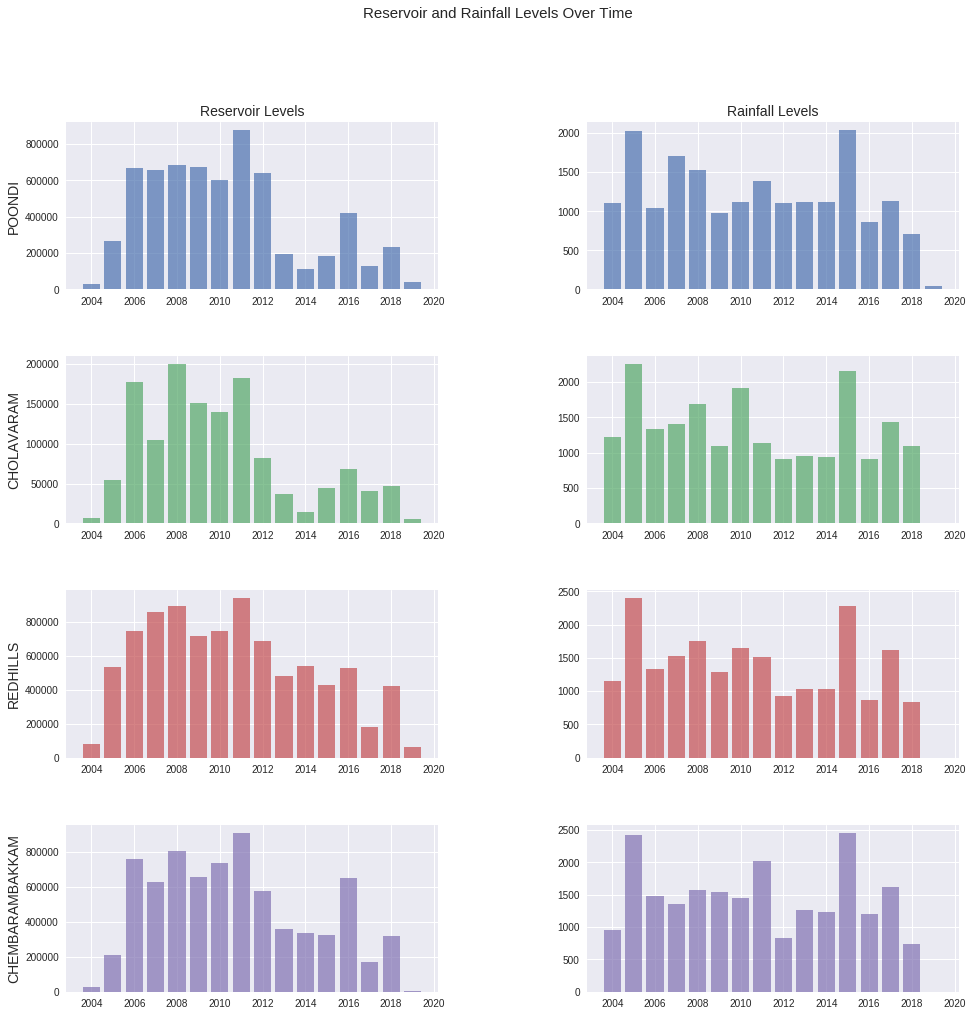

In [12]:
res_year = reservoir_levels.groupby(reservoir_levels.Date.dt.year).sum().reset_index()
rain_year = rainfall.groupby(rainfall.Date.dt.year).sum().reset_index()
plot_rainfall_and_reservoir_levels(res_year, rain_year, 'bar', 0.7)

A couple of things from the plots above.  We can clearly see firstly that reservoir levels are in fact decreasing.  All the regions are doing worse than in previous years.  Some regions are doing very poorly, like Cholavaram.  The reservoir levels there already start out smaller than all of the other regions.

Secondly, it does appear that 2018 was not a very good rainfall year (which is one of the listed reasons for the drought that's occurring in Chennai now).  Let's see if we can get a better picture of how bad 2018 was.

Text(0.5, 1.0, 'Rainfall Across Chennai by Year')

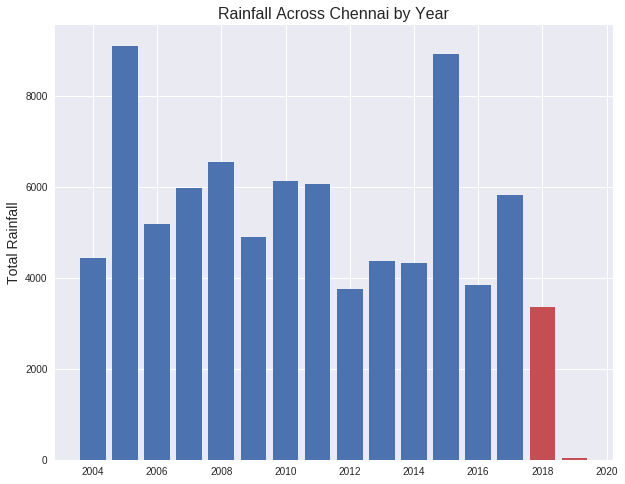

In [13]:
rain_year_aggregate = rain_year.iloc[:, 1:].sum(axis=1)
c = [colors[0] for i in range(rain_year_aggregate.shape[0] - 2)]
c += [colors[2] for i in range(2)]

plt.figure(figsize=(10, 8))
plt.bar(rain_year['Date'], rain_year_aggregate, color=c)
plt.ylabel('Total Rainfall', size=14)
plt.title('Rainfall Across Chennai by Year', size=16)

2018 does appear to have a low amount of rainfall, however there were similarly low amounts in 2016 and 2012-2014.  Chennai gets much of its water during monsoon season, which starts in October and goes through December.  According to [wikipedia](https://en.wikipedia.org/wiki/Climate_of_Tamil_Nadu) the dry season begins in February and goes through early June.  Perhaps then we should take a look at the reservoir levels at the start of the dry season.

In [14]:
is_february = reservoir_levels['Date'].dt.month == 2
is_day_one = reservoir_levels['Date'].dt.day == 1
dry_season_res_levels = reservoir_levels.loc[is_february & is_day_one, :].reset_index(drop=True)
dry_season_res_levels

,Date,POONDI,CHOLAVARAM,REDHILLS,CHEMBARAMBAKKAM
0,2004-02-01,4.8,0.0,220.0,0.0
1,2005-02-01,851.4,56.5,1458.0,275.0
2,2006-02-01,3035.0,721.0,2624.0,2843.0
3,2007-02-01,2565.0,545.0,3106.0,2157.0
4,2008-02-01,3061.0,867.0,3022.0,2960.0
5,2009-02-01,3025.0,778.0,2528.0,2679.0
6,2010-02-01,1493.0,686.0,2342.0,2254.0
7,2011-02-01,3108.0,840.0,3254.0,3080.0
8,2012-02-01,3048.0,495.0,2771.0,2719.0
9,2013-02-01,1359.0,398.0,2212.0,980.0


Text(0.5, 1.0, 'Reservoir Levels at the beginning of Dry Season in Chennai')

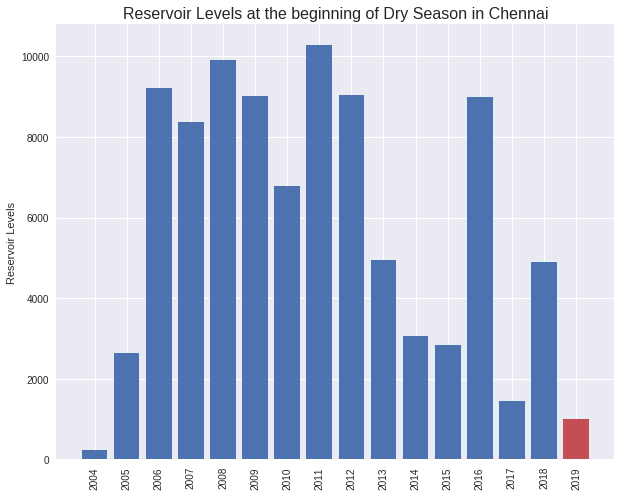

In [15]:
dry_season_res_all_regions = dry_season_res_levels.iloc[:, 1:].sum(axis=1)
x_tick_locations = range(dry_season_res_levels.shape[0])
c = [colors[0] for i in range(dry_season_res_levels.shape[0] - 1)]
c.append(colors[2])

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(x_tick_locations, dry_season_res_all_regions, color=c)
ax.set_xticks(x_tick_locations)
ax.set_xticklabels(dry_season_res_levels.Date.dt.strftime('%Y'), rotation=90)
ax.set_ylabel('Reservoir Levels')
ax.set_title('Reservoir Levels at the beginning of Dry Season in Chennai', size=16)

It certainly does appear that on February 1st, 2019 the Chennai experienced very low reservoir levels, less than any year other than 2004.  Before we move one let's visually test one last assumption, that our information from wikipedia is correct.  Below, we'll plot the trends in reservoir levels over time vs the season (dry season from February through June 15th, monsoon season from October through December, and the rest of the months as "regular" weather).

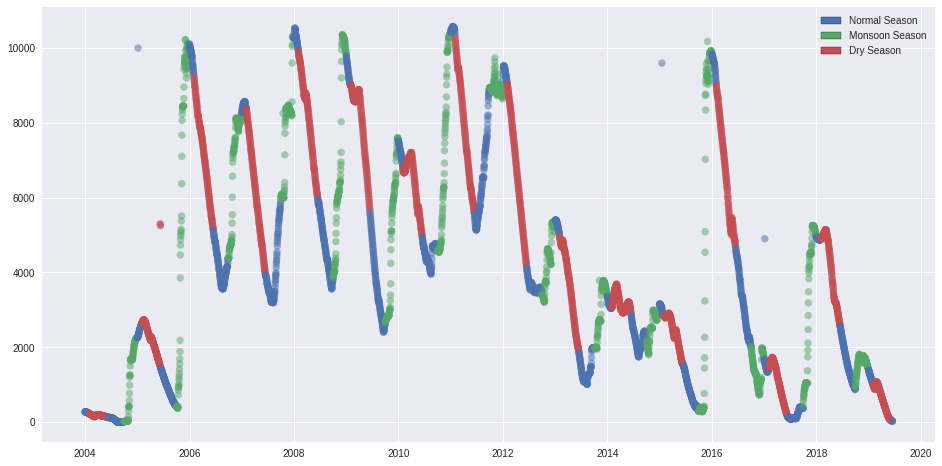

In [16]:
def assign_temporal_categories(date):
    """Given a date, determines whether to color for 'Monsoon', 'Dry', or 'Regular' season."""
    
    if date.month in [2, 3, 4, 5] or date.month == 6 and date.day <= 15:
        return colors[2]
    elif date.month in [10, 11, 12]:
        return colors[1]
    else:
        return colors[0]
    
c = reservoir_levels['Date'].apply(assign_temporal_categories, colors)
chennai_reservoirs = reservoir_levels.iloc[:, 1:].sum(axis=1)
plt.figure(figsize=(16, 8))
plt.scatter(reservoir_levels['Date'], chennai_reservoirs, color=c, alpha=0.5)
legend_labels = {'Normal Season':colors[0], 'Monsoon Season':colors[1], 'Dry Season':colors[2]}
leg_el = [mpatches.Patch(facecolor=value, edgecolor='k', label=key) for key, value in legend_labels.items()]
plt.legend(handles=leg_el)

Above we've plotted the total reservoir levels in Chennai per day (by summing the reservoir levels per region) and colored in the regions according to the weather breakdown from wikipedia.  As we can see, often during the dry season there is a drop in water levels, although this appears to continue after dry season until monsoon season hits again many times (we see this trend in 2008, 2009, and 2016).  Also, the monsoon season in 2017 didnt lead to a significant increase in reservoir levels, and the dry season in 2018 depleted reservoirs to critical levels.  The monsoon season in 2018 provided very little relief.

One thing to note, it appears that we may have some outlier data here.  Some of the points on the scatter plot, especially between 2004-2006, one point around 2015, and one point around 2017 appear to be quite off.  This could be incorrect data from faulty sensors, mis-entered data, it could be that some of the surrounding data is actually incorrect (that seems unlikely), etc.  At this point, if this would be a real issue for us, we'd have to go back to the source and determine why these numbers are so off.  Also, if we were to try to develop a model, we'd need to determine whether or not we should keep these outlier data.

---

## Modelling with Machine Learning Techniques

recurrent neural network (lstm)

In [17]:
def create_labeled_dataset(reservoir_levels, rainfall, target_days=30):
    """
    """
    
    assert(target_days > 0)
    result = reservoir_levels.iloc[:, 1:].sum(axis=1)
    result = result.shift(-target_days).rename('TOTAL')
    result = result.dropna().reset_index(drop=True)
    
    reservoir_levels = reservoir_levels.loc[reservoir_levels.index[:-target_days]].reset_index(drop=True)
    rainfall = rainfall.loc[rainfall.index[:-target_days]].reset_index(drop=True)
    temp = reservoir_levels.merge(rainfall, on='Date', how='outer')
    return temp.merge(result, left_index=True, right_index=True, how='outer')

labeled_data = create_labeled_dataset(reservoir_levels, rainfall)

In [18]:
features, expected = labeled_data.loc[:, labeled_data.columns[:-1]], labeled_data[labeled_data.columns[-1]].values

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import TimeSeriesSplit

In [20]:
class AddDayAndMonth(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        x['Month'] = x['Date'].dt.month
        x['Day'] = x['Date'].dt.day
        temp = x.drop('Date', axis=1)
        return temp.values

In [21]:
input_pipeline = Pipeline([
    ('day_month_adder', AddDayAndMonth()),
    ('std_scaler', StandardScaler()),
])

prepared_features = input_pipeline.fit_transform(features)

In [29]:
def split_train_test(frame, ratio=0.10, reshape=False):
    """
    """
    train_idx = int(frame.shape[0] * (1 - ratio))
    train, test = frame[:train_idx], frame[train_idx:]
    if not reshape:
        return train, test
    else:
        num_features = train.shape[1]
        train_size, test_size = train.shape[0], test.shape[0]
        return train.reshape(train_size, 1, num_features), test.reshape(test_size, 1, num_features)

x_train, x_test = split_train_test(prepared_features, reshape=True)
y_train, y_test = split_train_test(expected)

In [63]:
def shuffle_x_y(x, y):
    shuffle = [i for i in range(len(x))]
    np.random.shuffle(shuffle)
    return x[shuffle], y[shuffle]

xs_train, ys_train = shuffle_x_y(x_train, y_train)
test_data = shuffle_x_y(x_test, y_test)

In [69]:
from tensorflow import keras

def fit_model(x_train, y_train, validation_data=None, e=50, l=30, d=0.3, b=1):
    """
    """
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.LSTM(l, input_shape=(x_train.shape[1], x_train.shape[2]),
                                activation='relu', return_sequences=True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(d))
    
    model.add(keras.layers.LSTM(l, activation='relu', return_sequences=True))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(d))
    
    model.add(keras.layers.LSTM(l, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(d))
    
    model.add(keras.layers.Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=e, batch_size=b, validation_data=validation_data)
    return model

model = fit_model(xs_train, ys_train, validation_data=test_data)

Train on 5055 samples, validate on 562 samples
Epoch 1/50
5055/5055 [==============================] - 33s 7ms/sample - loss: 27094006.0820 - val_loss: 6787222.5496
Epoch 2/50
5055/5055 [==============================] - 27s 5ms/sample - loss: 19530108.6452 - val_loss: 8677445.9753
Epoch 3/50
5055/5055 [==============================] - 27s 5ms/sample - loss: 12765556.9611 - val_loss: 13763804.1109
Epoch 4/50
5055/5055 [==============================] - 27s 5ms/sample - loss: 9922642.4431 - val_loss: 18693143.1427
Epoch 5/50
5055/5055 [==============================] - 27s 5ms/sample - loss: 9386868.0406 - val_loss: 20372366.8858
Epoch 6/50
5055/5055 [==============================] - 27s 5ms/sample - loss: 9198490.4928 - val_loss: 22927361.4922
Epoch 7/50
1959/5055 [==========>...................] - ETA: 16s - loss: 9075083.2404

KeyboardInterrupt: 